# NFL Play Calling Machine Learning Challenge

#### Introduction

Hello! My name is James Dunning and in the following notebooks I will attempt to predict the play type called by NFL teams, using only information available prior to the play. In this first notebook, I will give a brief overview of the project and perform exploratory data analysis.

#### Project description:

In order to predict the type of each play, I will use a **Random Forest Classifier**, a supervised learning machine learning algorithm. For each play, the classifier will use the input data to make a prediction about the play type. I collected play-by-play data for each game, and used regular expression searches in Python to identify the type of each play. Overall, I have collected more than 626,000 plays across all seasons starting from 2000-2016.

Borrowing the the definition from [Wikipedia](https://en.wikipedia.org/wiki/American_football_plays), a play is a team's plan of action to move the ball down the field, normally occuring after either the kickoff or the center snaps the ball. For this project, I will only investigate plays where the center snaps the ball. The types of play, along with their definitions, is as follows:

* **Forward pass**:  A play where a member of the offense, usually the quarterback, throws the ball forward from behind the line of scrimmage.


* **Run**:  A play where a member of the offense is snapped, handed, or tossed the football while behind the line of scrimmage and proceeds to run past the line of scrimmage.


* **Spike**:  A play where the quarterback throws the ball directly into the ground, usually as a means of stopping the game clock.


* **Kneel**:  A play where the quarterback is snapped the ball and then takes a knee, usually as a means of running out the game clock in a safe manner.


* **Punt**:  A play where the ball is kicked downfield. This usually results in a transfer of possession of the football from one team to another.


* **Field Goal**:  A play where a team attempts to kick the ball through the uprights in the back of the endzone, in an attempt to score 3 points.






#### Load the data:

As a first step I'll load and inspect the dataset:

In [1]:
#Pandas is the library of choice for managing my datasets
import pandas as pd
import numpy as np

#Read in excel file as a pandas dataframe
data = pd.read_excel('..//data/data.xlsx', sheet_name = 'data')

print('There are {} rows and {} columns in the dataset.'.format(data.shape[0], data.shape[1]))

There are 626609 rows and 22 columns in the dataset.


#### Feature descriptions:

There are 22 features in the dataset, including my target feature, play_type. Below are the descriptions for the other 21 features:

* **down**: The offense has four downs to advance the ball 10 yards to gain a new set of four downs.
* **to_go**: How many yards the offense needs to move the ball forward to gain a new set of downs.
* **head_coach**: The head coach for the offense **at the begininng of the season**. This does not reflect any mid-season coaching changes.
* **off_coordinator**: The offensive cooardinator for the offense **at the begininng of the season**. This does not reflect any mid-season coaching changes.
* **offensive_scheme**: The general offensive strategy for the offense, as listed by [ProFootball Reference](http://www.pro-football-reference.com/).
* **defensive_alignment**: The positional alignment of the front seven defense players. A 4-3 defense has four down lineman and three linebackers, while a 3-4 defense has three down lineman and four linebackers.
* **timeouts_remaining**: How many timeouts are left at a team's disposal. Each team has three timeouts to start a half.
* **last_play_type**: The play_type class for the prior play by the offense. If it is the other team's first play of the drive, last_play_type is 'None'.
* **score_difference**: The offense's total score minus the defense's total score.
* **endzone_difference**: How many yards the offense is away from the opposing team's endzone.
* **goal_to_go**: A binary flag signaling if the offense's first down started within 10 yards of the opposing team's endzone.
* **last_play_gain**: How many yards the offense gained on the last play in the current drive.
* **time_remaining**: The total amount of seconds remaining until the end of the game.
* **time_remaining_half**: The total amount of seconds remaining until the end of the first half.
* **two_minute_warning**: A binary flag signaling if the play clock starts within 40 seconds of 2:00 remaining in the half.
* **kickoff_time**: What time during the day the game started.
* **season**: The year in which the game took place.
* **venue**: The type of stadium; either outdoors or dome.
* **surface**: The surface of the field, either grass or turf.
* **temperature**: Temperature in degrees Farenheit at kickoff.
* **wind**: Wind speed at kickoff, measured in miles per hour.

#### Inspect the data:

In [2]:
#Inspect the last 10 rows of the dataset
#These were the last 10 plays of regulation in SuperBowl LI. I have excluded overtime plays from this dataset.
data.tail(10)

,down,to_go,head_coach,off_coordinator,offensive_scheme,defensive_alignment,timeouts_remaining,play_type,last_play_type,score_difference,...,last_play_gain,time_remaining,time_remaining_half,two_minute_warning,kickoff_time,season,venue,surface,temperature,wind
626599,1,10,Bill Belichick,Josh McDaniels,Erhardt-Perkins,4-3,1,Pass,Pass,8,...,23.0,123,0,0,Late afternoon,2016,dome,turf,72.0,0.0
626600,1,10,Bill Belichick,Josh McDaniels,Erhardt-Perkins,4-3,1,Pass,Pass,8,...,20.0,117,0,0,Late afternoon,2016,dome,turf,72.0,0.0
626601,1,8,Bill Belichick,Josh McDaniels,Erhardt-Perkins,4-3,1,Pass,Pass,8,...,13.0,85,0,0,Late afternoon,2016,dome,turf,72.0,0.0
626602,2,1,Bill Belichick,Josh McDaniels,Erhardt-Perkins,4-3,1,Run,Pass,8,...,7.0,60,0,0,Late afternoon,2016,dome,turf,72.0,0.0
626603,1,10,Dan Quinn,Kyle Shanahan,West Coast,4-3,2,Pass,None,-2,...,NaN,52,0,0,Late afternoon,2016,dome,turf,72.0,0.0
626604,1,10,Dan Quinn,Kyle Shanahan,West Coast,4-3,2,Pass,Pass,0,...,12.0,32,0,0,Late afternoon,2016,dome,turf,72.0,0.0
626605,2,6,Dan Quinn,Kyle Shanahan,West Coast,4-3,2,Spike,Pass,0,...,4.0,19,0,0,Late afternoon,2016,dome,turf,72.0,0.0
626606,3,6,Dan Quinn,Kyle Shanahan,West Coast,4-3,2,Pass,Spike,0,...,0.0,18,0,0,Late afternoon,2016,dome,turf,72.0,0.0
626607,4,6,Dan Quinn,Kyle Shanahan,West Coast,4-3,2,Punt,Pass,0,...,0.0,11,0,0,Late afternoon,2016,dome,turf,72.0,0.0
626608,1,10,Bill Belichick,Josh McDaniels,Erhardt-Perkins,4-3,1,Run,None,0,...,NaN,3,0,0,Late afternoon,2016,dome,turf,72.0,0.0


In [3]:
#Get the data types for each feature
data.dtypes

down                     int64
to_go                    int64
head_coach              object
off_coordinator         object
offensive_scheme        object
defensive_alignment     object
timeouts_remaining       int64
play_type               object
last_play_type          object
score_difference         int64
endzone_distance         int64
goal_to_go               int64
last_play_gain         float64
time_remaining           int64
time_remaining_half      int64
two_minute_warning       int64
kickoff_time            object
season                   int64
venue                   object
surface                 object
temperature            float64
wind                   float64
dtype: object

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-pastel')
%matplotlib inline

C:\Users\James\Anaconda3\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


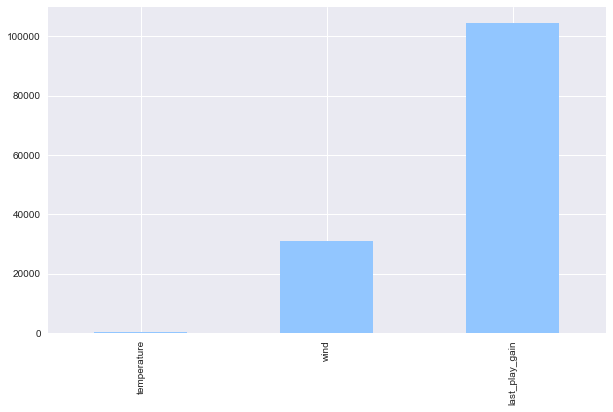

In [5]:
#Select missing data
missing = data.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)

fig, ax = plt.subplots(figsize=(10,6))
missing.plot.bar()

As we can see above, we are missing over 100,000 last_play_gain values. These null values occur on the first play of every drive; we will fill these null values with 0. Additionally, there are missing values for temperature and wind. During the data collection process, I manually set any missing temperature and wind values for games played in domes to 72 degrees and 0 mph, respectively. Therefore, these missing values are for games played outdoors. I'll set these missing values to the median values of temperature and wind for outdoor games.

In [6]:
#Set missing values to median outdoors values
median_temp = data[data.venue == 'outdoors']['temperature'].median()
median_wind = data[data.venue == 'outdoors']['wind'].median()

#Fill null values
data.temperature.fillna(median_temp, inplace = True)
data.wind.fillna(median_wind, inplace = True)
data.last_play_gain.fillna(0, inplace = True)

#### What is the distribution of numerical feature values across the samples?

Let's sanity check the summary statistics for our numerical features:

* **down**: Each team has four downs to gain another set of four downs, so the min of 1 and max of 4 is correct.
* **to_go**: The minimum value of 1 is correct, as 0 would be a new set of downs.
* **timeouts_remaining**: The values range from 0-3, which is correct.
* **score_difference**: The min and max should have the same absolute value, which is the case. One occurence of the 59 point difference came during a 2009 Patriots-Titans blowout in the snow.
* **endzone_distance**: The length of the field is 100 yards, so the range from 1-99 is correct, while the mean being near midfield is interesting.
* **goal_to_go**: Since this is a binary flag, min of 0 and max of 1 makes sense. The mean, 0.056 represents the percentage, 5.6%, of plays where the down is 1st, 2nd, 3rd, or 4th & Goal.
* **last_play_gain**: The largest loss on a play was 39 yards, while the largest gain came on a 95 yard play. These check out.
* **time_remaining**: The max of 3600 seconds equals 60 minutes, which is the length of a football game. The mean of 1,743 seconds is nearly halftime.

In [7]:
data.describe()

,down,to_go,timeouts_remaining,score_difference,endzone_distance,goal_to_go,last_play_gain,time_remaining,time_remaining_half,two_minute_warning,season,temperature,wind
count,626609.000000,626609.000000,626609.000000,626609.000000,626609.000000,626609.000000,626609.000000,626609.000000,626609.000000,626609.000000,626609.000000,626609.000000,626609.000000
mean,2.005871,8.571224,1.976228,-1.128160,51.835631,0.056399,4.224644,1743.078057,419.320511,0.010597,2008.064772,61.347660,6.878099
std,1.009702,4.091946,1.053442,10.809314,24.413442,0.230690,7.811625,1047.769310,571.664159,0.102394,4.895313,15.855916,5.841262
min,1.000000,1.000000,0.000000,-59.000000,1.000000,0.000000,-39.000000,0.000000,0.000000,0.000000,2000.000000,-6.000000,0.000000
25%,1.000000,6.000000,1.000000,-7.000000,33.000000,0.000000,0.000000,841.000000,0.000000,0.000000,2004.000000,51.000000,1.000000
50%,2.000000,10.000000,2.000000,0.000000,55.000000,0.000000,1.000000,1800.000000,0.000000,0.000000,2008.000000,66.000000,7.000000
75%,3.000000,10.000000,3.000000,4.000000,72.000000,0.000000,7.000000,2634.000000,834.000000,0.000000,2012.000000,72.000000,10.000000
max,4.000000,50.000000,3.000000,59.000000,99.000000,1.000000,95.000000,3600.000000,1800.000000,1.000000,2016.000000,109.000000,71.000000


#### What is the distribution of categorical features?

Let's sanity check the summary statistics for our categorical features:

The most common play_type, which is our target feature, is the forward pass. The most frequent head coach in the dataset is Bill Belichick, which make sense, as he is the longest tenured coach in the league. There are a large number of missing values for offensive coordinator, which I will split into dummy variables later on. The most common offensive scheme is the West Coast offense, while the most popular defensive aligment is the 4-3 defense.

In [8]:
data.describe(include=['O'])

,head_coach,off_coordinator,offensive_scheme,defensive_alignment,play_type,last_play_type,kickoff_time,venue,surface
count,626609,626609,626609,626609,626609,626609,626609,626609,626609
unique,113,132,9,2,6,5,4,2,2
top,Bill Belichick,None,West Coast,4-3,Pass,Pass,Early afternoon,outdoors,grass
freq,22060,36397,254217,435524,320747,291942,352118,474080,360713


#### What is the distribution of the target feature, play_type?

It is a good idea to understand the categorical distribution of our target feature. Below is a countplot of play_type, organized  by down. While the forward pass is the most common play_type overall, I notice that a run is more common than a pass on first down. My hypothesis is that teams become more aggressive on 2nd and 3rd down since they are running out of downs.

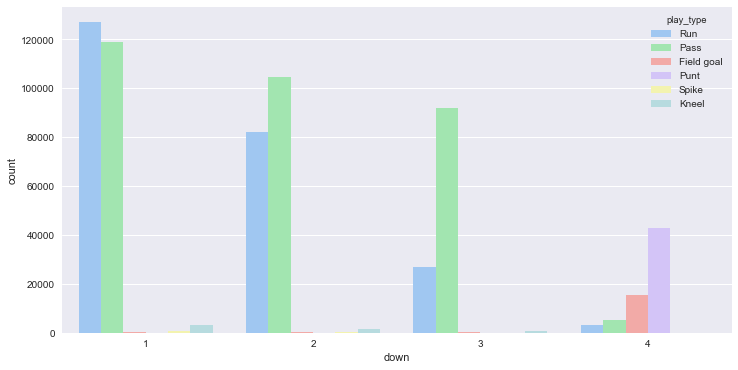

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(x="down", hue="play_type", data=data)

Below is another way of representing the distribution of our target feature, play_type. Each chart is a histogram plotting the distribution of a specific category of play_type.

The first row displays the distribution of play_type based on how far the offense is from the endzone.  As many drives start around the offense's 20 yard line, it makes sense to see peaks around endzone_distance = 80. A peak at endzone_distance = 1 for run plays makes sense, as teams are likely to call quarterback sneaks or power running plays when they are 1 yard from the endzone. Additionally, it is interesting to compare the distribution of Field goal vs Punt, as where Field goal ends Punt seems to begin.

The second row displays the distribution of play_type based on how many yards the offense needs to gain for a new set of downs. Since each set of downs starts at 1st & 10, the peak at 10 yards to go makes sense. Ignore to_go = 10, Run seems to be concentrated beween 0 and 9, while Pass has a much more right-skew.

The third row displays the distribution of play_type based on how far ahead/behind the offense is in points. While there understandably seems to be a higher propensity for the offense to pass while losing between 1-25 points, these distributions are much more similar than I would have expected.

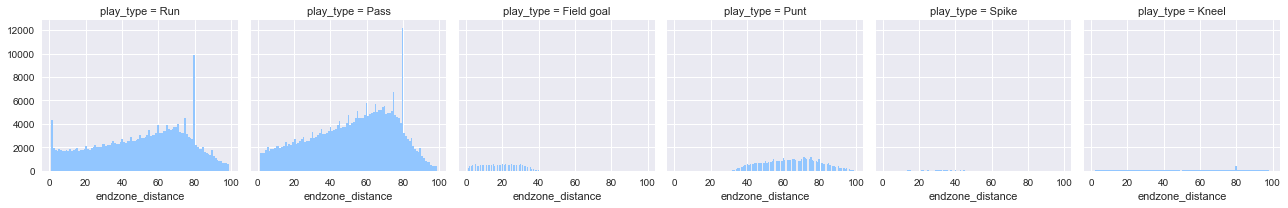

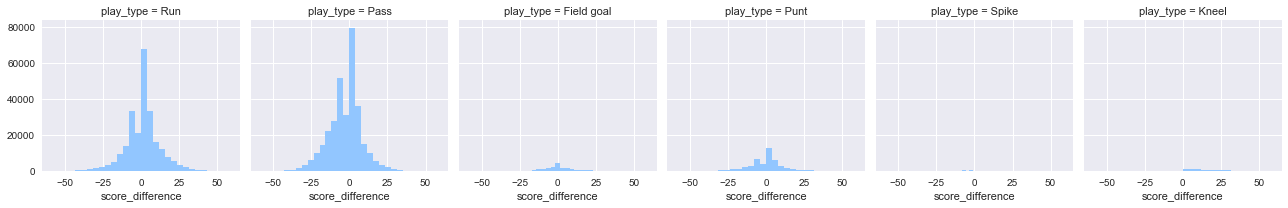

In [10]:
#Distribution by different numeric feature
g = sns.FacetGrid(data, col='play_type')
g.map(plt.hist, 'endzone_distance', bins=99)

g = sns.FacetGrid(data, col='play_type')
g.map(plt.hist, 'score_difference', bins=30)

Below I have combined the histograms in the second row above on to a single histogram. As we can see, Pass is the most popular play_type for every distance except 1 yard, where Run is the play_type of choice. Please note that this is for all downs, as we noticed before that Run was the most popular first down play, where to_go = 10.

(-1, 9)

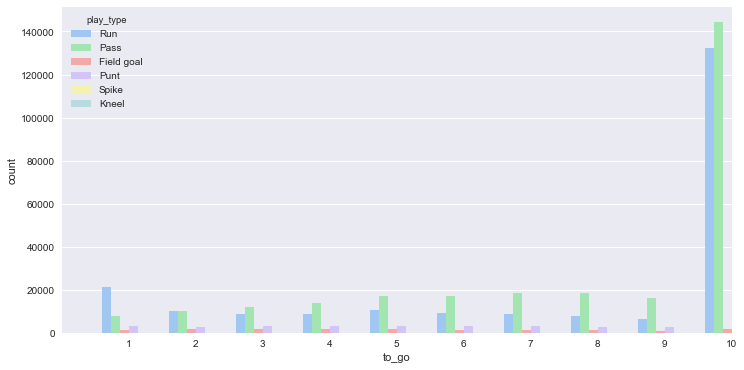

In [11]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(x="to_go", hue="play_type", data=data)
plt.xlim([-1, 9])

Finally, we have a comparison of Field goal vs. Punt by distance from the endzone. There is an interesting range around 35 yards from the endzone where teams are almost equally as likely to attempt a field goal as they are to punt the football. Obviously, this choice depends on situational factors that I hoped to capture in my dataset. It will be interesting to see if my classifier can correctly predict the field goal attempts from the 40+ yard line, as well as punts inside the 30 yard line.

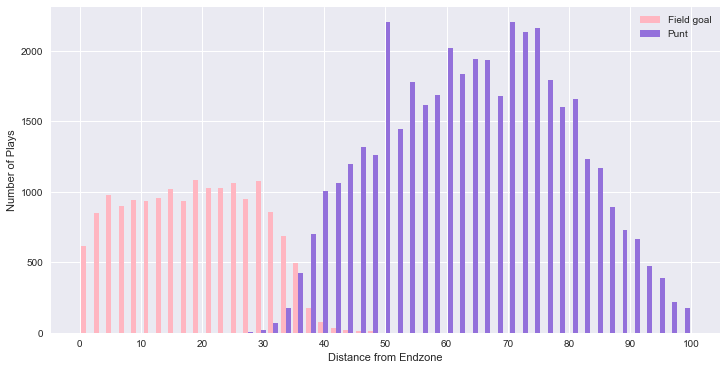

In [12]:
#Compare field goal and punt plays by distance from endzone
x = data[data.play_type == 'Field goal'].endzone_distance
y = data[data.play_type == 'Punt'].endzone_distance

#Set colors
colors = ['lightpink', 'mediumpurple']
labels = ['Field goal', 'Punt']
bins = np.linspace(0, 100, 50)

#Plot dual histogram
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist([x, y], bins = bins, color=colors, label = labels)
ax.legend(prop={'size': 10})
plt.ylabel('Number of Plays')
plt.xlabel('Distance from Endzone')

plt.xticks(np.arange(0, 101, 10))
plt.show()

#### Calculating our classifier accuracy benchmark:

Before I build a classifier in the next notebook, I want to define a simple accuracy benchmark. As we saw earlier in this notebook, Run is the popular play_type on first down, Pass on second and third down, and Punt on fourth down. If we were to make predictions, knowing nothing but what down it was, how would we do it? I would choose Run every time it was first down, Pass every time it was second and third down, and Punt on every fourth down. Obviously, this is extremely simplistic. However, it serves as a benchmark for our classifier. Our classifier should have a higher accuracy than this simplistic model, otherwise it is not of much use. Let's calculate this benchmark now:

In [13]:
#Calculate the lower bound of an acceptable classifier accuracy percentage
data_downs = data[['down', 'play_type']]
data_downs = pd.get_dummies(data_downs, columns = ['play_type'])

data_pct = data_downs.groupby('down').mean()
max_percent = data_pct.max(axis = 1)

data_counts = data_downs.groupby('down').sum()
max_count = data_counts.max(axis = 1)

benchmark = sum(max_percent * max_count) / sum(max_count)

print('The benchmark accuracy score for my classifier is {0:0.1f}%'.format(benchmark*100))

The benchmark accuracy score for my classifier is 60.1%


Hopefully my classifier will do much better than this. Click [here]() to view my next notebook!